# Homework №8

Взять датасет из google диска: https://drive.google.com/file/d/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.

In [25]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [26]:
!wget 'https://drive.google.com/file/d/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_' -O ab_stats.csv

In [27]:
!unzip data.zip

In [58]:
df = pd.read_csv('marketing_campaign.csv')
df

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


In [59]:
df.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [60]:
df.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64

In [88]:
df['converted'] = df['converted'].fillna(0)

In [89]:
df['converted'] = df['converted'].astype(int)

In [90]:
df.dtypes

user_id               object
date_served           object
marketing_channel     object
variant               object
language_displayed    object
converted              int64
dtype: object

In [100]:
from scipy.stats import shapiro

# проверка на нормальность распределения конверсии для каждой группы
control_normal = shapiro(control['converted'])[1] > 0.05
personalization_normal = shapiro(personalization['converted'])[1] > 0.05
# результаты
if control_normal:
    print('Конверсия в контрольной группе имеет нормальное распределение.')
else:
    print('Конверсия в контрольной группе не имеет нормального распределения.')

if personalization_normal:
    print('Конверсия в персонализированной группе имеет нормальное распределение.')
else:
    print('Конверсия в персонализированной группе не имеет нормального распределения.')


Конверсия в контрольной группе не имеет нормального распределения.
Конверсия в персонализированной группе не имеет нормального распределения.


In [92]:
from scipy.stats import ttest_ind

# делим данные на контрольную и персонализированную группы
control = df[df['variant'] == 'control']
personalization = df[df['variant'] == 'personalization']

# выполнить t-тест
stat, p_value = ttest_ind(control['converted'], personalization['converted'])
print(f'stat: {stat}')
print(f'p_value: {p_value}')

# результаты
if p_value < 0.05:
    print('Различие между конверсиями в контрольной и персонализированной группах статистически значимо.')
else:
    print('Различие между конверсиями в контрольной и персонализированной группах не является статистически значимым.')


stat: -11.34989621081538
p_value: 1.1258596007039894e-29
Различие между конверсиями в контрольной и персонализированной группах статистически значимо.


In [104]:
from scipy.stats import norm

control = df[df['variant'] == 'control']
personalization = df[df['variant'] == 'personalization']

conv_control = control['converted'].mean()
conv_personalization = personalization['converted'].mean()

se = np.sqrt((conv_control*(1-conv_control))/len(control) + (conv_personalization*(1-conv_personalization))/len(personalization))

z = (conv_personalization - conv_control) / se

p_value = norm.sf(abs(z))*2
print(f'p_value: {p_value}')

# результаты
if p_value < 0.05:
    print('Различие между конверсиями в контрольной и персонализированной группах статистически значимо.')
else:
    print('Различие между конверсиями в контрольной и персонализированной группах не является статистически значимым.')


p_value: 1.2552109233470097e-29
Различие между конверсиями в контрольной и персонализированной группах статистически значимо.


In [105]:
from scipy.stats import mannwhitneyu

# разделим данные на контрольную и персонализированную группы
control = df[df['variant'] == 'control']
personalization = df[df['variant'] == 'personalization']

# выполним тест Манна-Уитни
stat, p_value = mannwhitneyu(control['converted'], personalization['converted'])
print(f'stat: {stat}')
print(f'np_value: {p_value}')
# результаты
if p_value < 0.05:
    print('Различие между конверсиями в контрольной и персонализированной группах статистически значимо.')
else:
    print('Различие между конверсиями в контрольной и персонализированной группах не является статистически значимым.')


stat: 11712948.5
np_value: 1.6796821750456274e-29
Различие между конверсиями в контрольной и персонализированной группах статистически значимо.


<AxesSubplot:xlabel='converted', ylabel='Density'>

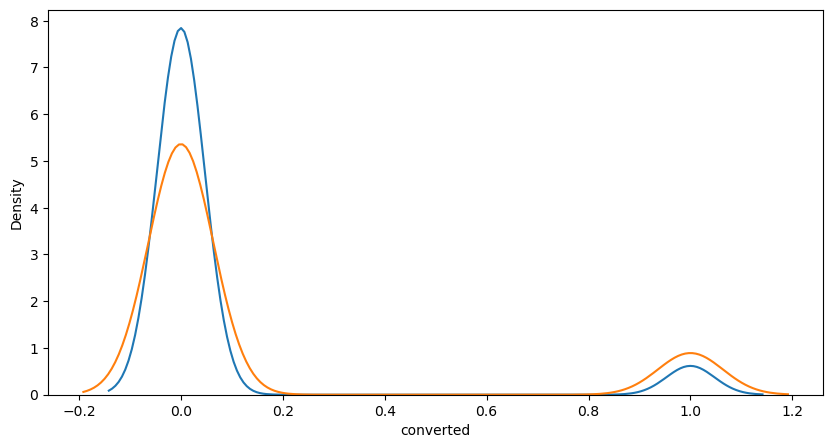

In [103]:
plt.figure(figsize=(10, 5))
sns.kdeplot(control['converted'], label='control')
sns.kdeplot(personalization['converted'], label='personalization')
